# 6. Evaluation
This notebook contains code for defining the evaluation metric for the musicians recommender.

The evaluation of the embedding-based recommender is challenging as we don't have the ground truth about classical performers and their similarities. I thus decided to compare my model to the following two measures of artist similarities:

1. <b>Spotify's 'related artists'</b>. These are the artists that appear on Spotify's "fans also like" section, which has been extracted from <a href="https://spotipy.readthedocs.io/en/2.13.0/?highlight=related#spotipy.client.Spotify.artist_related_artists">Spotify community's listening history.</a> Note that artists that appear in the "fans also like" section mostly play the same instrument as a given artist.  
2. <b>The artists' collaborators</b>. These are collaborators who have worked on an album together. Note that collaborators will often play distinct instruments.  

For each artist, I found 20 artists with the most similar embeddings. These are the 20 artists that the recommender engine would return. I then found (a) 20 people from Spotify's 'related artists' and (b) 20 people from the artist's collaborator. I then computed <b>precision</b>, <b>recall</b>, and <b>F1 scores</b> between the 20 recommended artists and those returned by (a) and (b). We'll refer to the two F1-scores as <b>related-artist F1</b> and <b>collaborator F1</b> scores.

The evaluation metrics defined in this notebook are used to select hyperparameters in notebook `6_hyperparameter_tuning.ipynb`

### Summary finding
I computed the related-artist F1 score and the collaborators F1 score for our recommender. The recommender has higher collaborator F1 score (0.317) than the related-artist F1 score (0.000). This is understandable, since node2vec finds artist embedding based on the collaboration patterns. 

In [ ]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import pickle
import random
import spotipy
plt.style.use("seaborn")

from gensim.models import Word2Vec, KeyedVectors
from musicians import *
from spotipy.oauth2 import SpotifyClientCredentials
from statistics import median

In [3]:
### Load data
# load trained model
model = Word2Vec.load("graph_80000/selected_model/word2vec.model")

# load data
with open('graph_80000/ID_name.pkl', 'rb') as f:
    ID_name = pickle.load(f)

with open('graph_80000/name_ID.pkl', 'rb') as f:
    name_ID = pickle.load(f)

# load existing graph and data
G = nx.read_gml("graph_80000/graph.gml")
# convert edge's 'album' attribute from list to set
for n1,n2,edge in G.edges(data=True):
    edge['albums'] = set(edge['albums'])

# 1. Comparison to "related artists" in Spotify
* For each artist that have been visited, I used spotify's API to find the his/her related artist. 

## 1(a) Get "related artists"  via Spotipy
* The following cell loads a dictionary of related_artists that have been computed in advance. 
* To create `related_artists`, run the function `get_related_artists`. 
Note that this can take a long time, and may result in a request timeout.

In [4]:
# load related_artists
with open('graph_80000/related_artists.pkl', 'rb') as f:
    related_artists = pickle.load(f)

In [5]:
# print related artists for test artists
test_artists = ['Daniel Barenboim',
                'Emil Gilels', 
                'Mitsuko Uchida', 
                'Mstislav Rostropovich',
                'Daniil Trifonov', 
                'Evgeny Kissin', 
                'Yuja Wang',
                'Herbert von Karajan',
                'Berliner Philharmoniker',
                'Wiener Philharmoniker',
                'Wolfgang Amadeus Mozart',
                'Ludwig van Beethoven',
                'Johannes Brahms',
                'Claude Debussy',
                'Sergei Rachmaninoff'
               ]
test_ID = [name_ID[item] for item in test_artists]
print("Printing related artists")
for ID in test_ID:
    print("*** Artists related to %s ***" %ID_name[ID])
    print([ID_name[item] for item in related_artists[ID]], '\n')

Printing related artists
*** Artists related to Daniel Barenboim ***
['Martha Argerich', 'Wilhelm Kempff', 'Tamás Vásáry', 'Christoph Eschenbach', 'Zoltán Kocsis', 'Stanislav Bunin', 'Vladimir Horowitz', 'Sviatoslav Richter', 'András Schiff', 'Ivo Pogorelich', 'Murray Perahia', 'Maria João Pires', 'Nelson Freire', 'Maurizio Pollini', 'Jean-Marc Luisada', 'Claudio Arrau', 'Alicia de Larrocha', 'Arturo Benedetti Michelangeli', 'Vladimir Ashkenazy', 'Anatol Ugorski'] 

*** Artists related to Emil Gilels ***
['Wilhelm Backhaus', 'Martha Argerich', 'Wilhelm Kempff', 'Géza Anda', 'Vladimir Horowitz', 'Sviatoslav Richter', 'András Schiff', 'Murray Perahia', 'Maria João Pires', 'Alexis Weissenberg', 'Walter Gieseking', 'Maurizio Pollini', 'Krystian Zimerman', 'Lazar Berman', 'Mikhail Pletnev', 'Friedrich Gulda', 'Claudio Arrau', 'Alicia de Larrocha', 'Arturo Benedetti Michelangeli', 'Artur Schnabel'] 

*** Artists related to Mitsuko Uchida ***
['Martha Argerich', 'Wilhelm Kempff', 'Christoph E

* Note that spotify's related artist will often (but not always) take into account the specific instrument played by the artist: Given a pianist, it will often show other related pianist. 
* In particular, given a composer, it will mostly return other famous composers.

## 1(b) Comparison of model to "related artists"

In [6]:
# select artists whose "related_artist" is nontrivial
related_artists_nontrivial = {ID:related for (ID,related) in related_artists.items() if related != set()}

# compare to related artists
related_precisions, related_recalls, related_F1 = compute_metrics(model, related_artists_nontrivial, 20)

median precision:  0.0
median recall:  0.0
median F1: 0.000


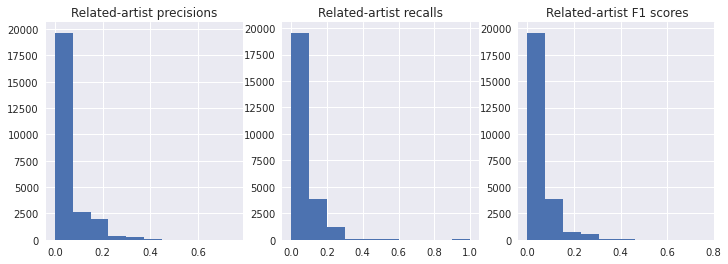

In [7]:
# plot histograms of precisions, recalls, F1

fig, ax = plt.subplots(ncols = 3, figsize = (12, 4))
ax[0].hist(related_precisions)
ax[0].set_title('Related-artist precisions')
ax[1].hist(related_recalls)
ax[1].set_title('Related-artist recalls')
ax[2].hist(related_F1)
ax[2].set_title('Related-artist F1 scores')
print('median precision: ', median(related_precisions))
print('median recall: ' , median(related_recalls))
print('median F1: %.3f' %median(related_F1))

The median precision, recall and F1 are all 0 because most artists scores were 0.

# 2. Comparison to collaborators
* For each visited artist, I find their collaborators (other artists that are connected the given artist in graph G)

## 2(a) Get list of collaborators

In [8]:
# load list of collaborators
with open('graph_80000/collaborators.pkl', 'rb') as f:
    collaborators = pickle.load(f)

To create the dictionary `collaborators`, run the following cell.

In [20]:
# for each of the 80,000 artists, find all artists that have distance 1 from the given artist
"""
with open('graph_80000/visited_artists.pkl', 'rb') as f:
    visited = pickle.load(f)
visited = set(visited)

collaborators = dict()

for artist in visited:
    collaborators[artist] = set(G.neighbors(artist))
    
# save
with open('graph_80000/collaborators.pkl', 'wb') as f:
    pickle.dump(collaborators, f)
"""

In [9]:
# print collaborators for test artists
print("printing collaborators")
for ID in test_ID:
    print("*** Collaborators to %s ***" %ID_name[ID])
    print([ID_name[item] for item in random.sample(collaborators[ID], 20)], '\n')

printing collaborators
*** Collaborators to Daniel Barenboim ***
['Sir John Barbirolli', 'Staatskapelle Berlin', 'Yulia Deyneka', 'Matti Salminen', 'Gioachino Rossini', 'Johannes Brahms', 'Catherine Wyn-Rogers', 'Claudine Castagnol', 'Edith Mathis', 'Fundación Barenboim-Saïd/EuroArts', 'Gaston Litaize', 'Leonard Bernstein', 'Johan Botha', 'Michael Barenboim', 'Itzhak Perlman/Orchestre de Paris/Daniel Barenboim', 'Berliner Philharmoniker', 'Vladimir Ashkenazy', 'Michel Hubert', 'Marjana Lipovsek', 'Paul Dukas'] 

*** Collaborators to Emil Gilels ***
['Fritz Reiner', 'Dmitri Tziganov', 'Sergei Prokofiev', 'Samuil Samosud', 'USSR State Radio and Television Symphony Orchestra', 'Daniil Shafran', 'Carl Maria von Weber', 'Karl Eliasberg', 'State Symphony Orchestra of the USSR', 'State Symphony Orchestra', 'Robert Irving', 'Mario Rossi', 'Sergei Rachmaninoff', 'Pancho Vladigerov', 'WDR Sinfonieorchester Köln', 'Manuel de Falla', 'Günter Wand', 'Ференц Лист', 'Franz Joseph Haydn', 'Philadelphi

## 2(b) Comparison of model to collaborators

In [11]:
# load trained model
model = Word2Vec.load("graph_80000/selected_model/word2vec.model")

In [12]:
collaborator_precisions, collaborator_recalls, collaborator_F1 = compute_metrics(model, collaborators, 20)

median precision: 0.350
median recall: 0.286
median F1: 0.286


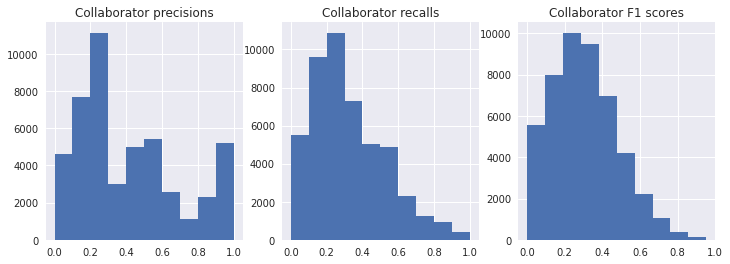

In [13]:
# plot histograms of precisions, recalls, F1 (OLD model (original))

fig, ax = plt.subplots(ncols = 3, figsize = (12, 4))
ax[0].hist(collaborator_precisions)
ax[0].set_title('Collaborator precisions')
ax[1].hist(collaborator_recalls)
ax[1].set_title('Collaborator recalls')
ax[2].hist(collaborator_F1)
ax[2].set_title('Collaborator F1 scores')
print('median precision: %.3f' %median(collaborator_precisions))
print('median recall: %.3f'  %median(collaborator_recalls))
print('median F1: %.3f' %median(collaborator_F1))

* Since the node2vec method finds artist embeddings based on the collaboration patterns, it's understandable that it has a better performance when compared to the list of collaborators.